# Sentiment Analysis with LoRA

In [1]:
import importlib
import sys

sys.path.append("..")  # Ensure the parent directory is in the path

# --- Standard Library ---
import os
from collections import defaultdict
from dataclasses import dataclass

# --- Third-Party Libraries ---
import torch
from torch import nn
import torch.nn.functional as F
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import classification_report
import seaborn as sns

# --- Local Application/Module Imports ---
from data_loader.data_loader import load_and_split_data, load_submission_data
from notebooks.dataset_dataloader import create_data_loader
import visualizations.visualizations
importlib.reload(visualizations.visualizations)
from visualizations.visualizations import *

import models.models
importlib.reload(models.models)
from models.models import *

# --- Notebook Configuration ---
%matplotlib inline
%config InlineBackend.figure_format='retina'

# --- Global Settings ---
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
os.environ["TOKENIZERS_PARALLELISM"] = "false"


In [2]:
@dataclass
class Config:
    batch_size: int
    model: str
    seed: int
    lr: float
    epochs: int
    dropout: float
    attention_dropout: float
    lora_r: int
    lora_alpha: float
    device: str
    num_classes: int
    max_len: int


# Determine the best available device
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

config = Config(
    batch_size=16,
    model="FacebookAI/roberta-large", #distilbert/distilbert-base-uncased",
    # "bert-large-cased", # "microsoft/deberta-v3-large", # "google/flan-t5-small", # TODO: small has 80 million tokens, but we can do ablation study going up to 11B for xxl model: https://huggingface.co/google/flan-t5-xxl
    seed=42,
    lr=3e-5,
    epochs=4,
    dropout=0.1,
    attention_dropout=0.1,
    # For LoRA
    lora_r=16,
    lora_alpha=32,  # a common choice is alpha = 2 * rank
    device=device,
    num_classes=3,
    max_len=64,
)

def set_seed(seed: int) -> None:
    import os
    import random

    import numpy as np

    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.mps.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")


set_seed(config.seed)

Random seed set as 42


In [3]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(config.model)
print(f"""
{tokenizer.name_or_path=}
{tokenizer.vocab_size=}
{tokenizer.model_max_length=}
""")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]


tokenizer.name_or_path='FacebookAI/roberta-large'
tokenizer.vocab_size=50265
tokenizer.model_max_length=512



In [4]:
from data_preprocessing.data_preprocessing import minimal_llm_preprocess

train_df, val_df, test_df = load_and_split_data()

# train_df = minimal_llm_preprocess(train_df)
# val_df = minimal_llm_preprocess(val_df)
# test_df = minimal_llm_preprocess(test_df)

train_data_loader = create_data_loader(train_df, tokenizer, config.max_len, config.batch_size)
val_data_loader = create_data_loader(val_df, tokenizer, config.max_len, config.batch_size)
test_data_loader = create_data_loader(test_df, tokenizer, config.max_len, config.batch_size)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tnorlha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/tnorlha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /Users/tnorlha/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/tnorlha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
model = load_blank_model(config)

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Making sure everything works:

-------

In [6]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [7]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 64])
torch.Size([16, 64])
torch.Size([16])


In [8]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape)  # batch size x seq length
print(attention_mask.shape)  # batch size x seq length

torch.Size([16, 64])
torch.Size([16, 64])


In [9]:
outputs = model(input_ids=input_ids, attention_mask=attention_mask)
probs = F.softmax(outputs.logits, dim=1).detach().cpu().numpy()

In [10]:
probs

array([[0.48711503, 0.26243293, 0.250452  ],
       [0.49163306, 0.2576795 , 0.25068748],
       [0.49224928, 0.25845617, 0.2492945 ],
       [0.4611974 , 0.2773104 , 0.2614922 ],
       [0.49148142, 0.2574048 , 0.25111374],
       [0.45804808, 0.28159967, 0.26035222],
       [0.5077322 , 0.241946  , 0.25032184],
       [0.48308435, 0.26245466, 0.25446108],
       [0.4687895 , 0.27836606, 0.25284448],
       [0.51996636, 0.2458942 , 0.23413941],
       [0.46794268, 0.27688417, 0.25517312],
       [0.49720687, 0.2602044 , 0.2425888 ],
       [0.49320522, 0.25702983, 0.24976496],
       [0.47106808, 0.27447966, 0.25445226],
       [0.5052319 , 0.24242628, 0.25234184],
       [0.49185905, 0.2562855 , 0.25185543]], dtype=float32)

-------

In [11]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr)
total_steps = len(train_data_loader) * config.epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [12]:
# from sklearn.utils.class_weight import compute_class_weight
#
# # Compute weights
# class_weights = compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(train_df.labels),
#     y=train_df.labels
# )
#
# # Convert to tensor and move to device
# weights = torch.tensor(class_weights, dtype=torch.float).to(device)
#
# # Use in loss function
# loss_fn = nn.CrossEntropyLoss(weight=weights).to(device)

loss_fn = nn.CrossEntropyLoss().to(device)

In [13]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(config.epochs):

    print(f'Epoch {epoch + 1}/{config.epochs}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
    )

    print(f'Train loss {train_loss} f1-score {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
    )

    print(f'Val   loss {val_loss} f1-score {val_acc}')
    print()

    history['train_f1'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_f1'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'roberta_large_4_epoch_batch_16.bin')
        best_accuracy = val_acc

Epoch 1/4
----------


Train loss 0.7512059316754225 f1-score 0.6826116930677081


Val   loss 0.6397946073042582 f1-score 0.7369280465145626

Epoch 2/4
----------


Train loss 0.5992156394665201 f1-score 0.7664477670312767


Val   loss 0.6039040629899185 f1-score 0.7714955976318096

Epoch 3/4
----------


Train loss 0.4670113806020793 f1-score 0.8276388674982704


Val   loss 0.5811068005772404 f1-score 0.7871804332942866

Epoch 4/4
----------


Train loss 0.3510382550116355 f1-score 0.8804141906589789


Val   loss 0.6281667190643263 f1-score 0.7962442210168326

CPU times: user 1h 14min 20s, sys: 21min 24s, total: 1h 35min 44s
Wall time: 2h 14min 21s


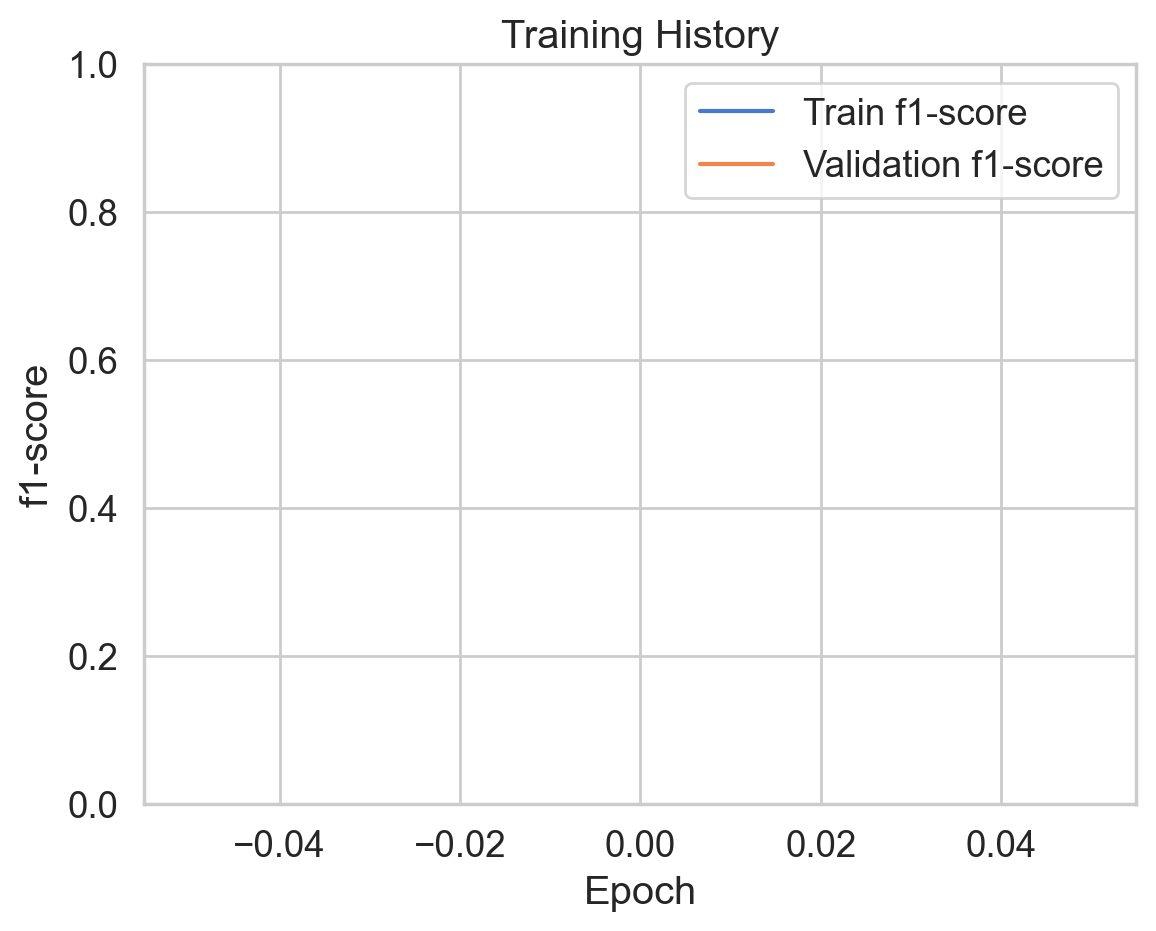

In [14]:
plot_training_history(history)

## Evaluation

In [15]:
test_acc, _ = eval_model(
    model,
    test_data_loader,
    loss_fn,
    device
)

test_acc.item()

0.7953173814832107

In [16]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader,
    device
)

In [17]:
class_names = ['negative', 'neutral', 'positive']
print(classification_report(y_test, y_pred, labels=[0, 1, 2], target_names=class_names))

              precision    recall  f1-score   support

    negative       0.77      0.74      0.76      2191
     neutral       0.83      0.83      0.83      4915
    positive       0.79      0.81      0.80      3104

    accuracy                           0.81     10210
   macro avg       0.80      0.79      0.80     10210
weighted avg       0.81      0.81      0.81     10210



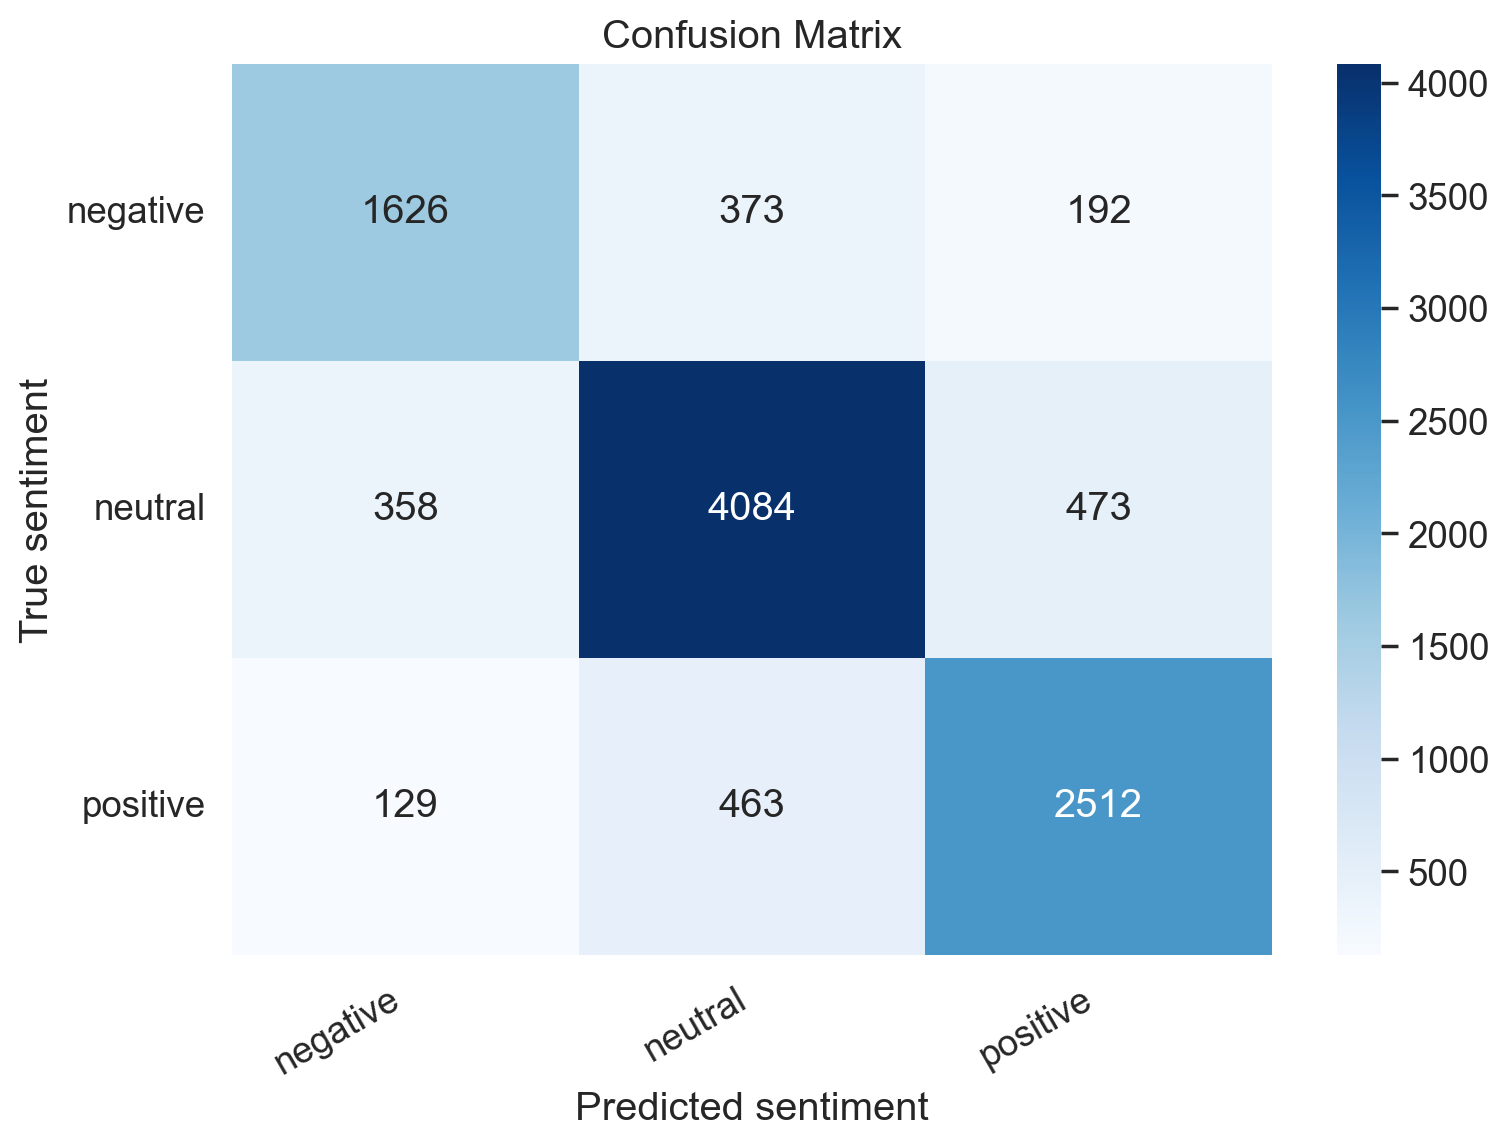

In [18]:
plot_confusion_matrix(y_test, y_pred, class_names)

## Submission

In [19]:
submission_df = load_submission_data()

submission_data_loader = create_data_loader(submission_df, tokenizer, config.max_len, config.batch_size)

In [20]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    submission_data_loader,
    device
)

In [21]:
label_map = {0: "negative", 1: "neutral", 2: "positive"}
generate_submission(y_pred, label_map=label_map)

Submission file saved to ../submissions/submission.csv


In [22]:
train_df.size

163354

In [23]:
val_df.size

20420

In [24]:
train_df

,text,labels
id,,
93866,I'm just glad I wasn't paying the bill.,0
49185,We decided to give it a try.,1
8401,Food was tasty.,2
89069,When ` science fiction ' takes advantage of th...,0
51789,I went here to have my iPhone 6 screen replaced.,1
...,...,...
38939,I got the sundae and asked for extra chocolate...,1
26923,We had to go there because they said the one i...,1
2436,Asking how we met like it's their business.,1
